### Data munging, labels, outliers, etc. 

In [1]:
import pymongo
import sys
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt 
import seaborn as sns
sys.path.append("..")
from src.utils import plots
%matplotlib inline

In [2]:
# Access the mongodb database containg neuromorpho collection
client = pymongo.MongoClient("mongodb://localhost/27017/")
db = client.aibs
nm_coll = db.nmorpho

In [3]:
# Get only the drosophila control data with relatively complete reconstruction
drosophila = nm_coll.find({"species":"drosophila melanogaster", 
                           "physical_Integrity": {"$in": ["Dendrites Complete", "Dendrites Moderate", "Neurites Moderate",  'Dendrites & Axon Complete',"Axon Complete"]}, 
                           "experiment_condition": "Control"})

In [4]:
# Get neuron id and celltype for labeling
neuron_list = [(a["neuron_id"], a["cell_type"]) for a in drosophila]
# Retrieve morphometry data
morphometry = {a[0]:db.morphometry.find_one({"neuron_id":a[0]}) for a in neuron_list}
df = pd.DataFrame(morphometry).T

In [5]:
# Observe columns
for i,a in enumerate(df.columns): 
    print(i,a)

0 _id
1 bif_ampl_local
2 branch_Order
3 contraction
4 depth
5 diameter
6 eucDistance
7 fractal_Dim
8 fragmentation
9 height
10 length
11 n_bifs
12 n_branch
13 n_stems
14 neuron_id
15 neuron_name
16 partition_asymmetry
17 pathDistance
18 pk_classic
19 soma_Surface
20 surface
21 volume
22 width


In [6]:
# Observe data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26454 entries, 1173 to 81424
Data columns (total 23 columns):
_id                    26454 non-null object
bif_ampl_local         26454 non-null object
branch_Order           26454 non-null object
contraction            26454 non-null object
depth                  26454 non-null object
diameter               26454 non-null object
eucDistance            26454 non-null object
fractal_Dim            26454 non-null object
fragmentation          26454 non-null object
height                 26454 non-null object
length                 26454 non-null object
n_bifs                 26454 non-null object
n_branch               26454 non-null object
n_stems                26454 non-null object
neuron_id              26454 non-null object
neuron_name            26454 non-null object
partition_asymmetry    26454 non-null object
pathDistance           26454 non-null object
pk_classic             26454 non-null object
soma_Surface           7747 non-n

In [7]:
# Observe samples 
df.head()

,_id,bif_ampl_local,branch_Order,contraction,depth,diameter,eucDistance,fractal_Dim,fragmentation,height,...,n_stems,neuron_id,neuron_name,partition_asymmetry,pathDistance,pk_classic,soma_Surface,surface,volume,width
1173,5afb214f9d477a8da41150a1,92.07,17,0.91,72.23,1.08,91.83,1.04,290,129.86,...,1,1173,12070404c1,0.59,123.35,1.77,None,2318.51,716.09,44.09
1174,5afb214f9d477a8da41150a2,87.59,14,0.91,34.93,0.87,101.82,1.04,468,116.04,...,1,1174,CT12T2,0.6,122.74,1.82,None,2230.54,617.22,82.2
1175,5afb214f9d477a8da41150a3,81.47,18,0.92,47.38,0.79,108.99,1.04,357,124.1,...,1,1175,DB12L2,0.66,142.08,1.81,None,1628.39,355.34,73.38
1176,5afb214f9d477a8da41150a4,96.34,11,0.91,49,0.73,84.09,1.03,269,132.18,...,1,1176,DL24T2,0.56,149.23,1.98,None,1014.74,192.99,29.95
1177,5afb214f9d477a8da41150a5,97,14,0.9,41,0.71,100.47,1.04,305,131.4,...,1,1177,DL41L2,0.58,126.88,1.93,None,1101.33,217.87,30.45


In [8]:
# Convert numeric type features to floats
num_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22]

for a in num_features:
    df.loc[:,df.columns[a]] = df.loc[:,df.columns[a]].astype("float")

In [9]:
# Convert ints
int_features = [2,8,11,12,13]
for a in int_features:
    df.loc[:,df.columns[a]] = df.loc[:,df.columns[a]].astype("int")

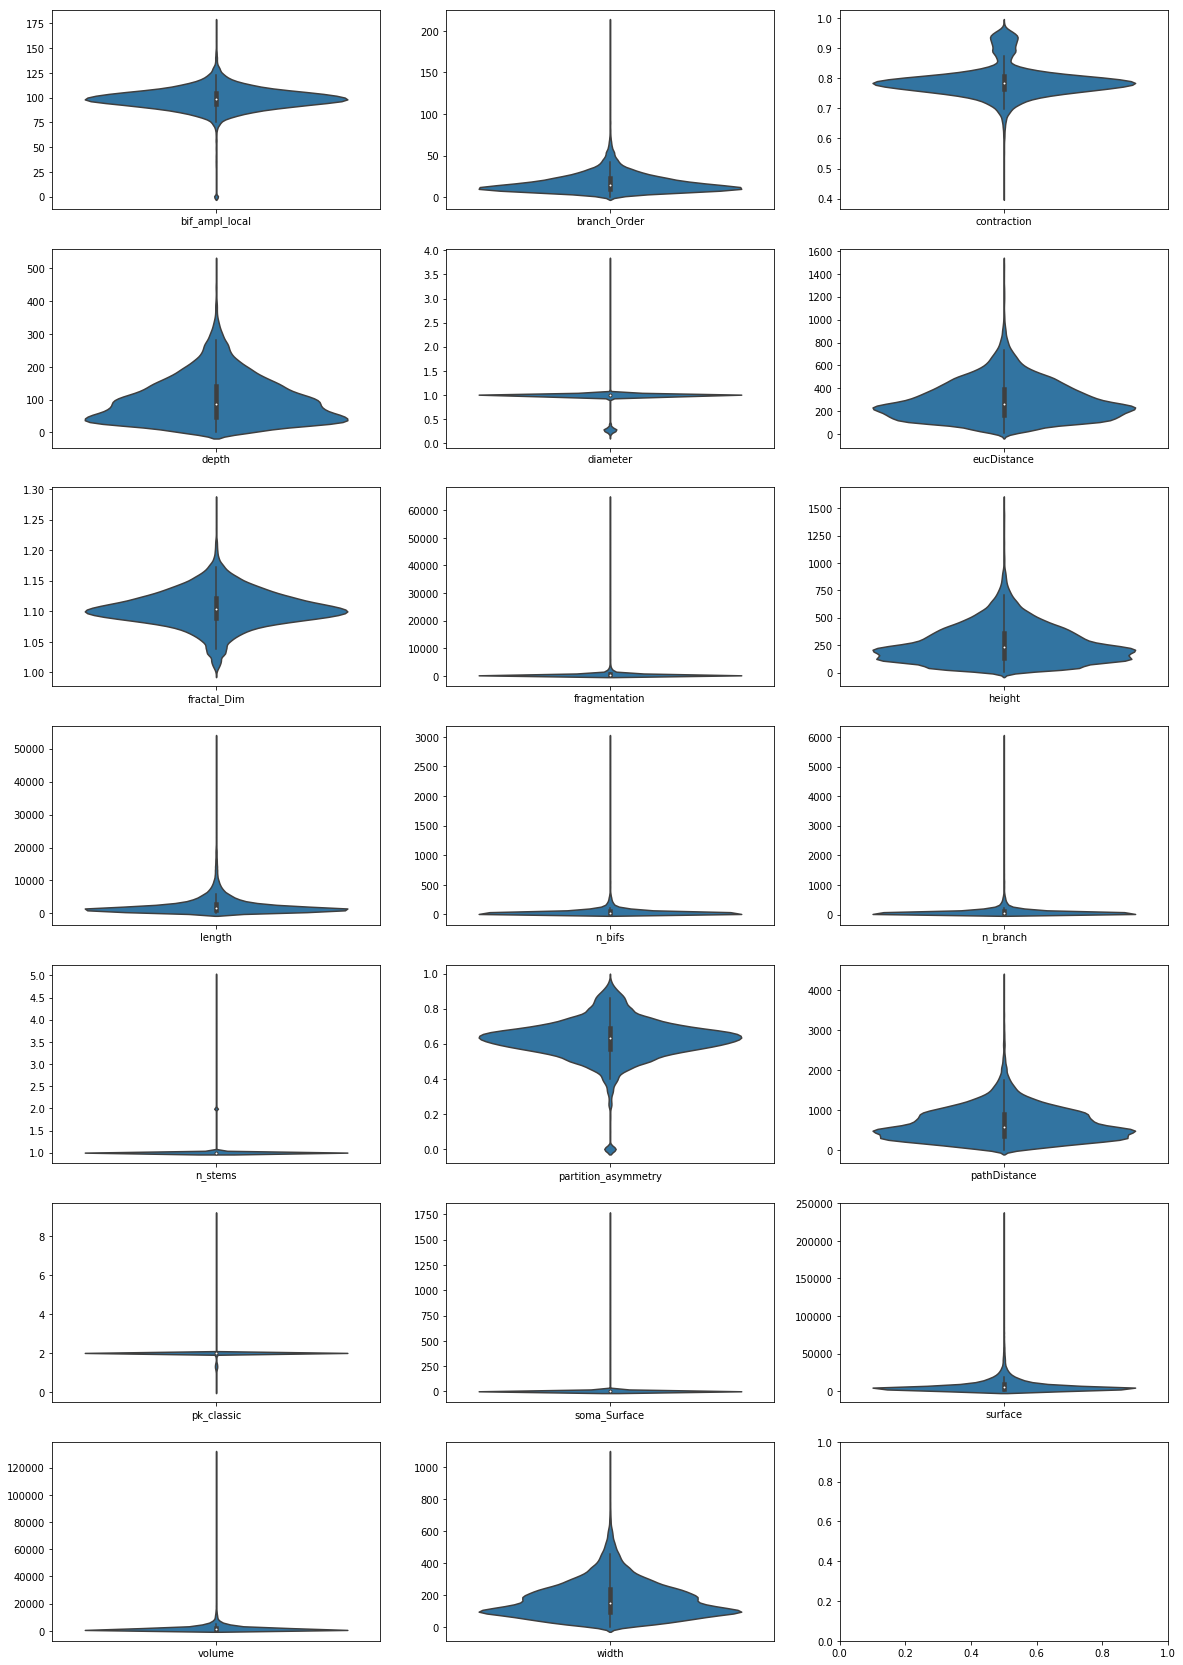

In [10]:
# Visualize data with violin plot
fig, ax = plt.subplots(7,3,figsize=(20,30))
axs = ax.flatten()
for i in range(len(num_features)): 
        sns.violinplot(data=df.iloc[:,[num_features[i]]], ax=axs[i])

## Use neurotransmitter as labels

In [11]:
# Get labels 
label = [a[1] for a in neuron_list]

In [12]:
labels = []
for a in label: 
    labels.extend(a)

In [13]:
# Get all the neurotransmitters
transmitters = ["GABAergic", "cholinergic","dopaminergic","glutamatergic","octapaminergic", "octopaminergic","peptidergic", "serotonergic"]

In [14]:
# Use neurotransmitter as labels for current data
nt_label = [] 
for i,a in enumerate(label): 
    b = list(filter(lambda x: x in transmitters, a))
    if b: 
        nt_label.append(*b)
    else: 
        nt_label.append("")

df['transmitter'] = nt_label

In [15]:
# Deal with typo 
df.loc[df.transmitter=="octapaminergic","transmitter"] = "octopaminergic"

In [16]:
# Create mew dataframe selecting neurons labeled with neurotransmitter
df2 = df[df.transmitter !=""]

In [17]:
# Drop peptidergic as there's only 1 
df2 = df2.drop(index = df2[df2.transmitter=="peptidergic"].index)

In [18]:
df2.transmitter.value_counts()

glutamatergic     6016
GABAergic         3702
cholinergic       3379
serotonergic      2212
dopaminergic       862
octopaminergic     271
Name: transmitter, dtype: int64

In [19]:
# Change label dtype to category
df2.loc[:,"transmitter"] = df2.transmitter.astype('category')

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 11471 to 80935
Data columns (total 24 columns):
_id                    16442 non-null object
bif_ampl_local         16442 non-null float64
branch_Order           16442 non-null int64
contraction            16442 non-null float64
depth                  16442 non-null float64
diameter               16442 non-null float64
eucDistance            16442 non-null float64
fractal_Dim            16442 non-null float64
fragmentation          16442 non-null int64
height                 16442 non-null float64
length                 16442 non-null float64
n_bifs                 16442 non-null int64
n_branch               16442 non-null int64
n_stems                16442 non-null int64
neuron_id              16442 non-null object
neuron_name            16442 non-null object
partition_asymmetry    16442 non-null float64
pathDistance           16442 non-null float64
pk_classic             16442 non-null float64
soma_Surface           402

## Observe, handle outliers

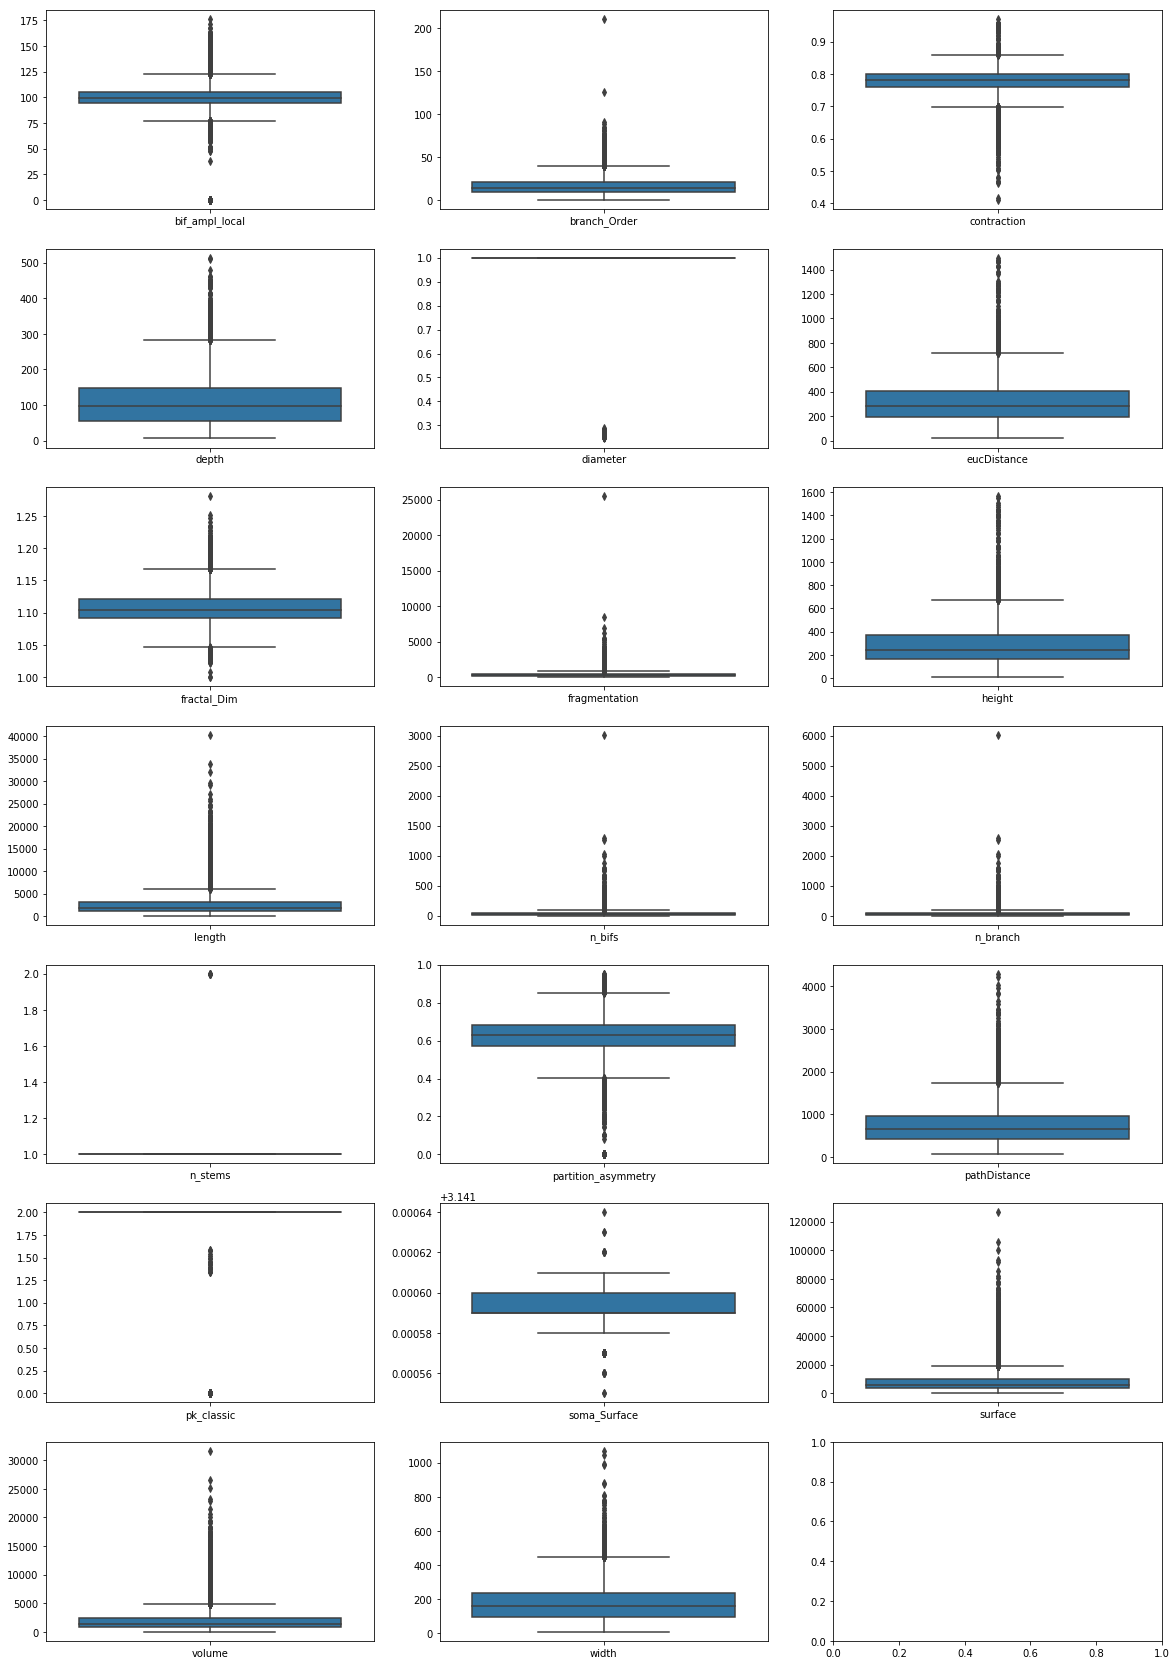

In [21]:
fig, ax = plt.subplots(7,3,figsize=(20,30))
axs = ax.flatten()
for i in range(len(num_features)): 
        sns.boxplot(data=df2.iloc[:,[num_features[i]]], ax=axs[i])

### Take a conservative approach to eliminating outliers.  
I could probably shave off more, but leave be for now, deal as necessary. 

In [22]:
# Outliers to drop 
df2.fragmentation.idxmax()

74747

In [23]:
df2.branch_Order.idxmax()

74747

In [24]:
df2.n_bifs.idxmax()

74747

In [25]:
df2.n_bifs.idxmax()

74747

In [26]:
df2.loc[74747,:]

_id                    5afb23c59d477a8da4126e6e
bif_ampl_local                          89.8319
branch_Order                                211
contraction                            0.948917
depth                                     94.83
diameter                               0.271508
eucDistance                             99.9191
fractal_Dim                             1.06374
fragmentation                             25464
height                                    48.56
length                                  8129.76
n_bifs                                     3009
n_branch                                   6020
n_stems                                       2
neuron_id                                 74747
neuron_name                            MB-APL-2
partition_asymmetry                    0.758019
pathDistance                            313.303
pk_classic                              1.43022
soma_Surface                                NaN
surface                                 

In [27]:
# Look at metadata for 74747
nm_coll.find_one({"neuron_id":74747})

{'_id': ObjectId('5ad655489d477a7106d22ae0'),
 'neuron_id': 74747,
 'neuron_name': 'MB-APL-2',
 'archive': 'FlyEM',
 'note': '',
 'age_classification': 'not reported',
 'brain_region': ['protocerebrum', 'mushroom body', 'alpha'],
 'cell_type': ['principal cell', 'GABAergic', 'anterior paired lateral-(APL)'],
 'species': 'drosophila melanogaster',
 'strain': 'Canton S G1 x w1118',
 'scientific_name': None,
 'stain': 'osmium tetroxide/uranyl acetate',
 'experiment_condition': 'Control',
 'protocol': 'in vitro',
 'slicing_direction': 'Not reported',
 'reconstruction_software': 'neuTu, Raveler',
 'objective_type': 'electron microscopy',
 'original_format': 'neuTu, Raveler.swc',
 'domain': 'Neurites, No Soma',
 'attributes': 'Diameter, 3D, Angles',
 'magnification': None,
 'upload_date': '2017-11-28',
 'deposition_date': '2017-07-19',
 'shrinkage_reported': 'N',
 'shrinkage_corrected': '',
 'reported_value': None,
 'reported_xy': None,
 'reported_z': None,
 'corrected_value': None,
 'correc

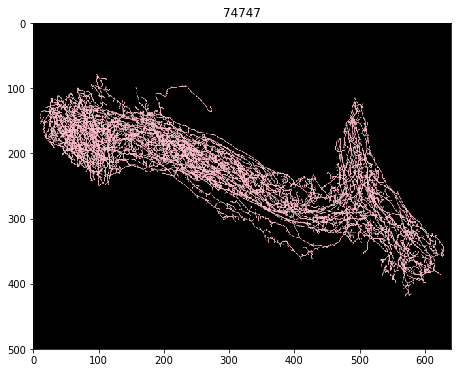

In [28]:
# Visualize 
plots.plot_2dimage(74747)

In [29]:
# Drop 
df2.drop(index=74747, inplace=True)

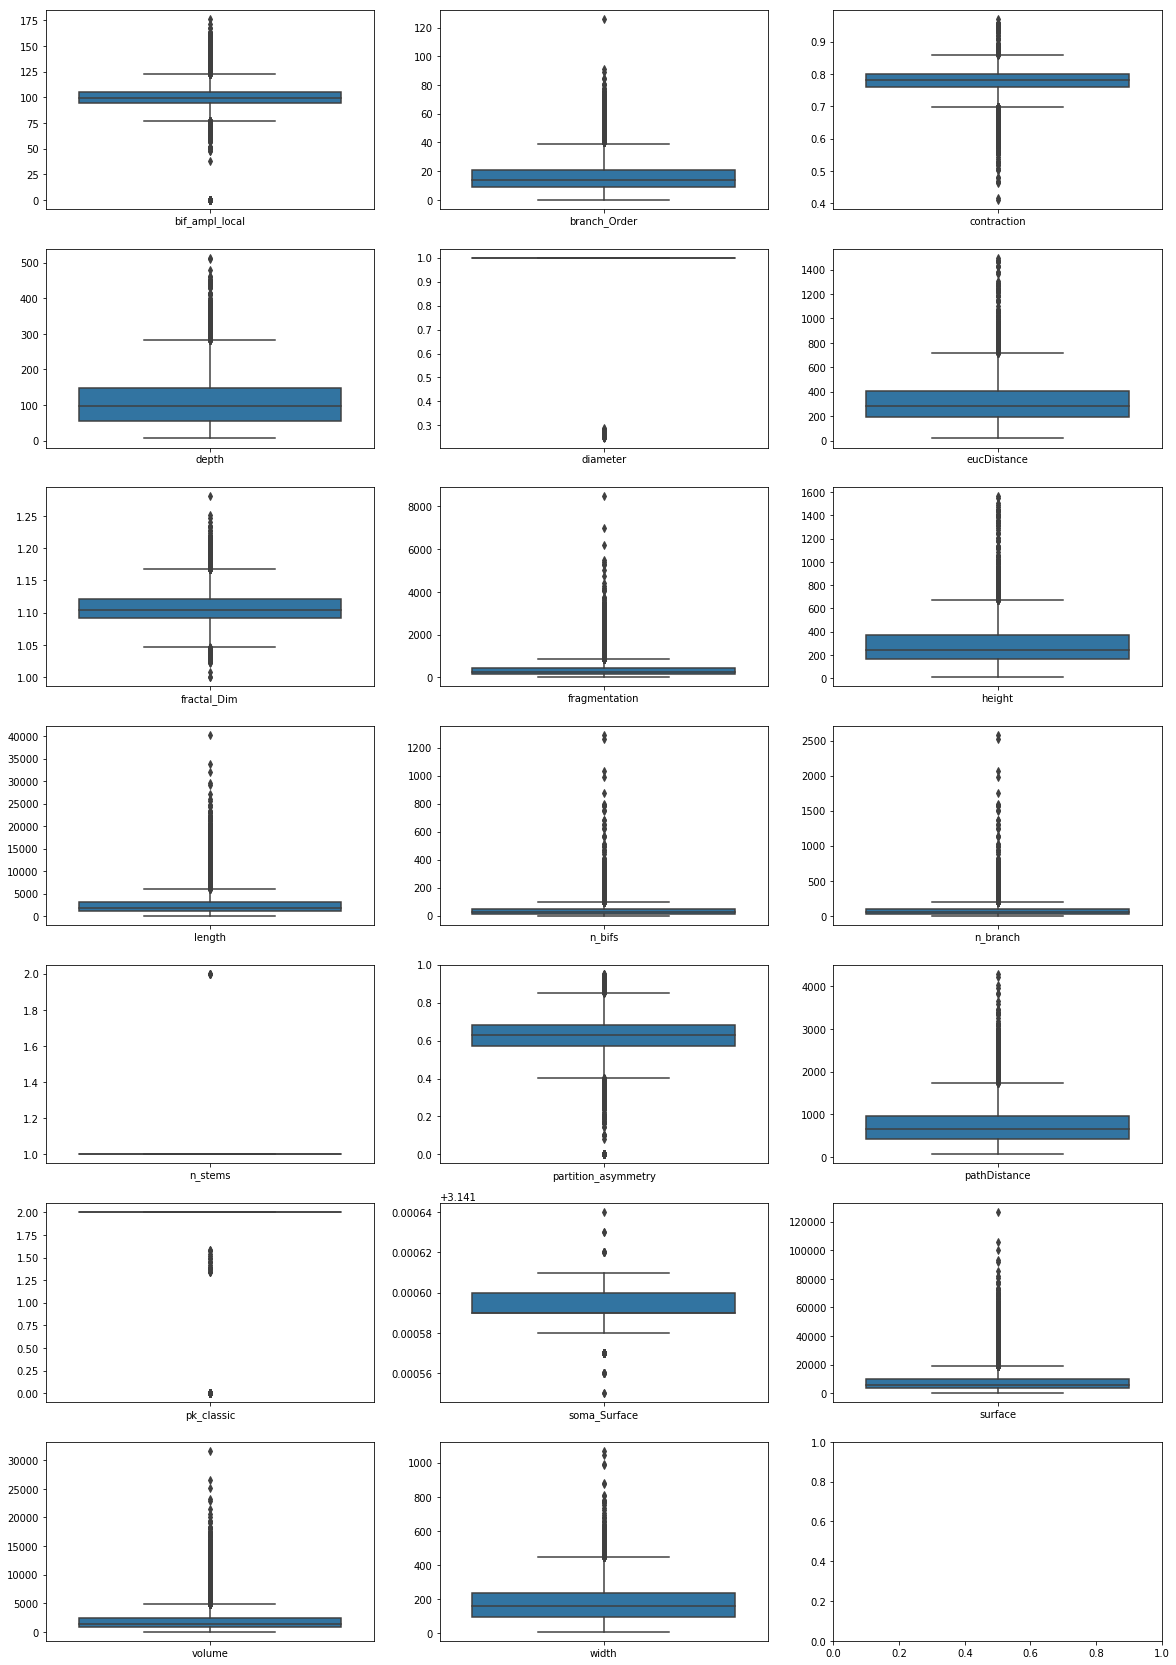

In [30]:
fig, ax = plt.subplots(7,3,figsize=(20,30))
axs = ax.flatten()
for i in range(len(num_features)): 
        sns.boxplot(data=df2.iloc[:,[num_features[i]]], ax=axs[i])

In [31]:
# Save to csv file 
df2.to_csv("../data/df_munged.csv")